In [ ]:
hyperparameters = {
    "learning_rate": 1e-5,
    "batch_size": 64,
    "embed_dim": 256,
    "num_heads": 8,
    "num_layers": 4,
    "dropout": 0.1,
    "ff_dim": 2048,
    "epochs": 100
}
info = {
    "dataset_size": "100K",
    "precision": "FP16",
    "dir_name": "position_model"
}

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

data_path = f"/content/drive/MyDrive/dataset/{info['dataset_size']}.csv"

data = pd.read_csv(data_path)
data.shape

(50000, 10)

In [22]:
x = data['sequence']
y_original = data['genomic_pos']

In [ ]:
from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y_original.values.reshape(-1, 1))

In [24]:
import pickle

def get_codon(seq, k=3):
    return [seq[i:i+k] for i in range(len(seq) - k + 1)]

def get_tensor(text):
    return [vocab.get(codons.lower(), vocab['<UNK>']) for codons in get_codon(text)]

with open("vocab.pkl", "rb") as file:
  vocab = pickle.load(file)

In [25]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

class CustomDataset(Dataset):
  def __init__(self, x, y):
    self.x_frame = x
    self.y_frame = y

  def __len__(self):
    return len(self.x_frame)

  def __getitem__(self, index):
    x = torch.tensor(get_tensor(self.x_frame[index]), dtype=torch.long)
    y = torch.tensor(self.y_frame[index], dtype=torch.float16)
    return x, y

In [26]:
dataset = CustomDataset(x, y)

In [27]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [28]:
train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'])

In [29]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).unsqueeze(1)

        div_term = torch.exp((torch.arange(0, embed_dim, 2)) * (-math.log(10000.0) / embed_dim))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

class Transformer(nn.Module):
    def __init__(self, embed_dim=512, num_heads=8, num_layers=6, ff_dim=2048, dropout=0.1, vocab_size=10000, max_len=5000):
        super(Transformer, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.position_encoding = PositionalEncoding(embed_dim=embed_dim, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=num_layers
        )

        self.y_labels_out = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.position_encoding(x)

        x = self.encoder(x)
        x = x.mean(dim=1)

        y_label_out = self.y_labels_out(x)
        return y_label_out

In [30]:
model = Transformer(
    embed_dim=hyperparameters['embed_dim'],
    num_heads=hyperparameters['num_heads'],
    num_layers=hyperparameters['num_layers'],
    ff_dim=hyperparameters['ff_dim'],
    dropout=hyperparameters['dropout'],
    vocab_size=len(vocab),
    max_len=200
)

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Transformer(
  (embeddings): Embedding(66, 256)
  (position_encoding): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (y_labels_out): Linear(in_features=256, out_features=1, bias=True)
)

In [32]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {num_params}")

Total trainable parameters: 5277441


In [33]:
from transformers import get_linear_schedule_with_warmup

mse = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'], weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()

num_training_steps = len(train_loader) * hyperparameters['epochs']
num_warmup_steps = 500

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

/tmp/ipython-input-3396957962.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [34]:
def train32(model, loader, mse, optimizer):
    model.train()

    running_loss = 0.0
    running_mae = 0.0

    for x, y in loader:
        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = mse(output, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * len(x)

        mae = torch.nn.functional.l1_loss(output, y, reduction='sum')
        running_mae += mae.item()

    avg_loss = running_loss / len(loader.dataset)
    avg_mae = running_mae / len(loader.dataset)

    return avg_loss, avg_mae


def train16(model, loader, mse, optimizer, scaler, scheduler):
    model.train()
    running_loss = 0.0
    running_mae = 0.0

    for x, y in loader:
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)

        with torch.cuda.amp.autocast():
            output = model(x)
            loss = mse(output, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()

        running_loss += loss.item() * len(x)

        mae = torch.nn.functional.l1_loss(output, y, reduction='sum')
        running_mae += mae.item()

    train_avg_loss = running_loss / len(loader.dataset)
    train_avg_mae = running_mae / len(loader.dataset)

    return train_avg_loss, train_avg_mae


In [35]:
def validation(model, loader, mse):
    model.eval()
    running_loss = 0.0
    running_mae = 0.0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            if info['precision'] == 'FP16':
                with torch.cuda.amp.autocast():
                    output = model(x)
                    loss = mse(output, y)
            else:
                output = model(x)
                loss = mse(output, y)

            running_loss += loss.item() * len(x)

            mae = torch.nn.functional.l1_loss(output, y, reduction='sum')
            running_mae += mae.item()

    val_avg_loss = running_loss / len(loader.dataset)
    val_avg_mae = running_mae / len(loader.dataset)

    return val_avg_loss, val_avg_mae


In [ ]:
import os

patience = 10
best_val_loss = float('inf')
counter = 0
early_stop = False

train_avg_loss_history = []
train_avg_mae_history = []
val_avg_loss_history = []
val_avg_mae_history = []

save_dir = f"/content/drive/MyDrive/{info['dir_name']}"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(hyperparameters['epochs'] + 1):
    if info['precision'] == 'FP16':
        train_loss, train_mae = train16(
            model,
            train_loader,
            mse,
            optimizer,
            scaler,
            scheduler
        )
    else:
        train_loss, train_mae = train32(
            model,
            train_loader,
            mse,
            optimizer
        )

    val_loss, val_mae = validation(
        model,
        test_loader,
        mse
    )

    train_avg_loss_history.append(train_loss)
    train_avg_mae_history.append(train_mae)
    val_avg_loss_history.append(val_loss)
    val_avg_mae_history.append(val_mae)

    print(f"Epoch ({epoch+1}/{hyperparameters['epochs']}): "
          f"Train Average Loss = {train_loss:.4f}, "
          f"Train Average MAE = {train_mae:.4f}, "
          f"Validation Average Loss = {val_loss:.4f}, "
          f"Validation Average MAE = {val_mae:.4f}")

    if (epoch + 1) % 10 == 0:
        checkpoint_path = f"{save_dir}/model_epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_avg_loss': train_loss,
            'train_avg_mae': train_mae,
            'val_avg_loss': val_loss,
            'val_avg_mae': val_mae,
            'y_scaler': y_scaler
        }, checkpoint_path)
        print(f"Model saved at {checkpoint_path}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        print(f"No improvement in val loss Counter = {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered!")
            early_stop = True
            break

/tmp/ipython-input-3898942725.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/tmp/ipython-input-335290065.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch (1/100): Train Average Loss = 0.0802, Train Average MAE = 0.2293, Validation Average Loss = 0.0748, Validation Average MAE = 0.2339
Epoch (2/100): Train Average Loss = 0.0660, Train Average MAE = 0.2147, Validation Average Loss = 0.0637, Validation Average MAE = 0.2090
Epoch (3/100): Train Average Loss = 0.0646, Train Average MAE = 0.2129, Validation Average Loss = 0.0644, Validation Average MAE = 0.2157
No improvement in val loss Counter = 1/10
Epoch (4/100): Train Average Loss = 0.0645, Train Average MAE = 0.2129, Validation Average Loss = 0.0638, Validation Average MAE = 0.2144
No improvement in val loss Counter = 2/10
Epoch (5/100): Train Average Loss = 0.0644, Train Average MAE = 0.2129, Validation Average Loss = 0.0681, Validation Average MAE = 0.2230
No improvement in val loss Counter = 3/10
Epoch (6/100): Train Average Loss = 0.0647, Train Average MAE = 0.2130, Validation Average Loss = 0.0641, Validation Average MAE = 0.2151
No improvement in val loss Counter = 4/10
Epoc

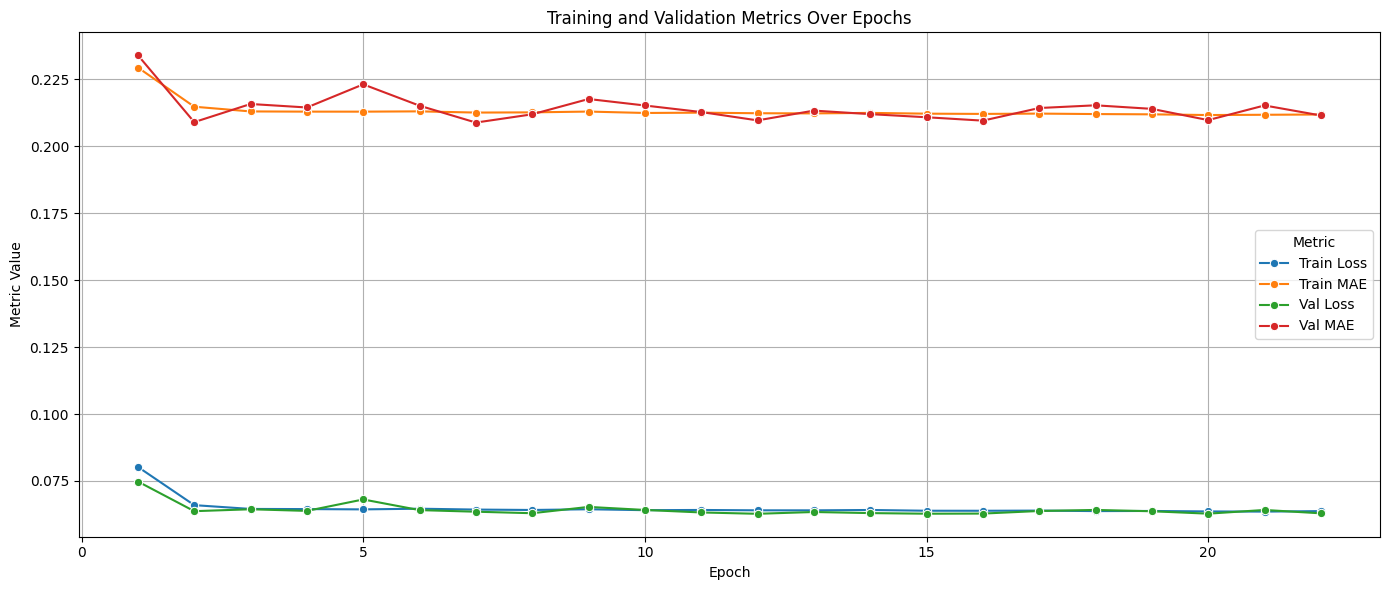

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_avg_loss_history) + 1))

df = pd.DataFrame({
    'Epoch': epochs * 4,
    'Value': train_avg_loss_history + train_avg_mae_history + val_avg_loss_history + val_avg_mae_history,
    'Metric': ['Train Loss'] * len(epochs) +
              ['Train MAE'] * len(epochs) +
              ['Val Loss'] * len(epochs) +
              ['Val MAE'] * len(epochs)
})

plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='Epoch', y='Value', hue='Metric', marker='o')
plt.title('Training and Validation Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.grid(True)
plt.tight_layout()
plt.show()

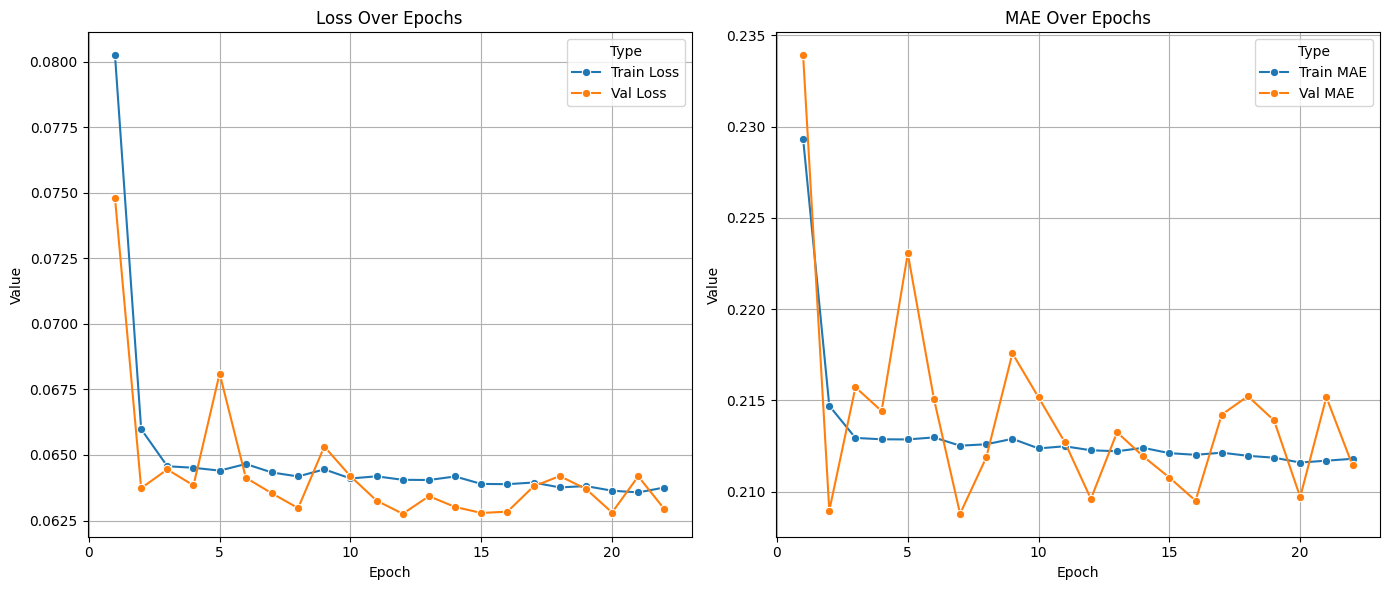

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_avg_loss_history) + 1))

loss_df = pd.DataFrame({
    'Epoch': epochs * 2,
    'Value': train_avg_loss_history + val_avg_loss_history,
    'Type': ['Train Loss'] * len(epochs) + ['Val Loss'] * len(epochs)
})

mae_df = pd.DataFrame({
    'Epoch': epochs * 2,
    'Value': train_avg_mae_history + val_avg_mae_history,
    'Type': ['Train MAE'] * len(epochs) + ['Val MAE'] * len(epochs)
})

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.lineplot(data=loss_df, x='Epoch', y='Value', hue='Type', ax=axes[0], marker='o')
axes[0].set_title('Loss Over Epochs')
axes[0].grid(True)

sns.lineplot(data=mae_df, x='Epoch', y='Value', hue='Type', ax=axes[1], marker='o')
axes[1].set_title('MAE Over Epochs')
axes[1].grid(True)

plt.tight_layout()
plt.show()